# Timeseries of NASA SMAP soil moisture initiated at co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [14]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

In [38]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_AM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[4]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

#### Read and subset to Colorado Landslides >= year 2015

In [2]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file)
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-01-01']

glc_co_gt2015.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2015-04-27,Steamboat Today,http://www.steamboattoday.com/news/2015/jun/12...,6994,4/27/15 0:00,NaN,Howelsen Hill,The work will involve repositioning the chairl...,Howelsen Hill,1km,landslide,...,US,Colorado,12088.0,Steamboat Springs,0.83297,3/24/16 17:17,11/20/17 15:17,2/15/18 15:51,-106.8393,40.4802
2015-05-11,ABC7,http://www.thedenverchannel.com/news/local-new...,7047,5/11/15 0:00,NaN,"Wyoming Circle, Golden",The soil on North Table Mountain is so saturat...,"Wyoming Circle, Golden",exact,mudslide,...,US,Colorado,18867.0,Golden,2.66154,7/2/15 14:21,11/20/17 15:17,2/15/18 15:51,-105.2274,39.7790
2015-05-13,KKTV 11,http://www.kktv.com/home/headlines/Homeowners-...,7060,5/13/15 0:00,NaN,"6250 Fencerail Hts Colorado Springs, CO",The almost nonstop rain last week and over the...,"6250 Fencerail Hts Colorado Springs, CO",exact,landslide,...,US,Colorado,6680.0,Air Force Academy,8.38116,7/2/15 18:54,11/20/17 15:17,2/15/18 15:51,-104.8365,38.9218
2015-05-19,Fox 21 News,http://fox21news.com/2015/05/21/rock-slide-and...,7053,5/19/15 0:00,NaN,Phantom Canyon Road,“Our road crews went further up Phantom Canyon...,Phantom Canyon Road,10km,landslide,...,US,Colorado,3582.0,Penrose,15.49683,7/2/15 16:23,11/20/17 15:17,2/15/18 15:51,-105.0948,38.5526
2015-05-19,Wet Mountain Tribune,http://www.wetmountaintribune.com/home.asp?i=8...,7051,5/19/15 0:00,NaN,"Mile Marker 10, Oak Creek Grade Road",A severe mudslide closed Oak Creek Grade on Tu...,"Mile Marker 10, Oak Creek Grade Road",5km,mudslide,...,US,Colorado,3546.0,Lincoln Park,15.35824,7/2/15 16:06,11/20/17 15:17,2/15/18 15:51,-105.2706,38.2967


#### Get all SMAP data files, sorted

In [145]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 'smap_l3')
smap_files = sorted(glob(os.path.join(data_dir, '*.h5')))

#### Peak inside a file to search which variables I need

In [4]:
f = h5py.File(smap_files[0], 'r')
print(smap_files[0])

print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
print('\n')

# Lets focus on the AM overpass for this example
group_id=list(f.keys())[1]; 

i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1
f.close()

/Users/jwitte/earth-analytics/data/capstone/smap_l3/SMAP_L3_SM_P_20150331_R17000_002.h5
Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	landcover_class
12	landcover_class_fraction
13	latitude
14	latitude_centroid
15	longitude
16	longitude_centroid
17	radar_water_body_fraction
18	retrieval_qual_flag
19	retrieval_qual_flag_dca
20	retrieval_qual_flag_scah
21	retrieval_qual_flag_scav
22	roughness_coefficient
23	roughness_coefficient_dca
24	roughness_coefficient_scah
25	roughness_coefficient_scav
26	soil_moisture
27	soil_moisture_dca
28	soil_moisture_error
29	soil_moisture_scah
30	soil_moisture_scav
31	sta

#### These are the variables that will provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 26 | cm<sup>3</sup>/cm<sup>3</sup> |
| albedo | 2 | N/A |
| clay_fraction | 8 | N/A |
| surface_temperature | 33 | K |
| vegetation_opacity | 48 | N/A |
| vegetation_water_content | 52 | kg/m<sup>2</sup> |

#### Load the EASE2 grid lon and lat datasets. These can be found on the NSIDC website.

In [8]:
# Reshape to dimensions of the SMAP data above
f = h5py.File(smap_files[0], 'r')
sm_data = read_smap(f, group_id, 26)
f.close()
lats = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lats.964x406x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'EASE2_M36km.lons.964x406x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)

### Let's work with one file

### Co-locate to a single landslide event

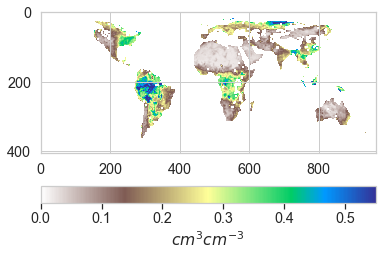

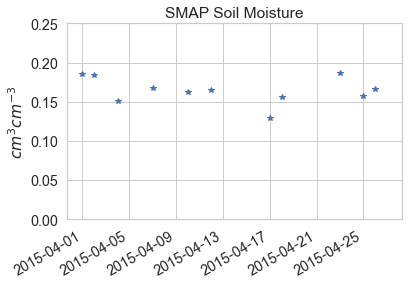

In [95]:
periods = 27
glc_date = pd.date_range(glc_co_gt2015.index[0], periods=periods,
                         freq='-1D').strftime('%Y%m%d')

# Loop over the X days and create list of DataArrays
sm_dates = []
sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

i = 0
for dd in glc_date:
    # Find the file
    file = [x for x in smap_files if re.findall(dd, x)]

    # Retrieve the variables
    sm_data_3d[:, :, i], time_i = read_smap(file[0], 26)
    sm_dates.append(time_i)
    i += 1

sm_mean = np.nanmean(sm_data_3d,2)
sm_mean.shape
plt.imshow(sm_mean,vmin=0.,vmax=0.55,cmap='terrain_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

# take the +/- 5 deg mean around the Landslide event
N_lat = glc_co_gt2015.latitude[0]+0.25
S_lat = glc_co_gt2015.latitude[0]-0.25
W_lon = glc_co_gt2015.longitude[0]-0.25
E_lon = glc_co_gt2015.longitude[0]+0.25

subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
sm_mean = np.empty([periods])
for i in np.arange(0, sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:, :, i]
    sm_mean[i] = np.nanmean(sm_2d[subset])

# Lets create a pandas series to plot the data
smData = {'sm': sm_mean}
sm = pd.DataFrame(smData)
sm['sm_date'] = sm_dates
sm = sm.set_index('sm_date')
sm['landslideID'] = glc_co_gt2015.event_id[0]

# plot the time series
fig, ax1 = plt.subplots()
ax1.plot(sm.index, sm, 'b*')
ax1.set_ylim([0, 0.25])
fig.autofmt_xdate()
ax1.set_ylabel('$cm^3 cm^{-3}$')
plt.title('SMAP Soil Moisture');

#### Read a second time period to learn about appending 

In [121]:
periods = 30
glc_date = pd.date_range(glc_co_gt2015.index[1], periods=periods,
                         freq='-1D').strftime('%Y%m%d')

# Loop over the X days and create list of DataArrays
sm_dates = []
sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

i = 0
for dd in glc_date:
    # Find the file
    file = [x for x in smap_files if re.findall(dd, x)]

    # Retrieve the variables
    sm_data_3d[:, :, i], time_i = read_smap(file[0], 26)
    sm_dates.append(time_i)
    i += 1

# take the +/- 5 deg mean around the Landslide event
N_lat = glc_co_gt2015.latitude[1]+0.25
S_lat = glc_co_gt2015.latitude[1]-0.25
W_lon = glc_co_gt2015.longitude[1]-0.25
E_lon = glc_co_gt2015.longitude[1]+0.25

subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
sm_mean = np.empty([periods])
for i in np.arange(0, sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:, :, i]
    sm_mean[i] = np.nanmean(sm_2d[subset])

# Lets create a pandas series to plot the data
smData = {'sm': sm_mean}
sm2 = pd.DataFrame(smData)
sm2['sm_date'] = sm_dates
sm2 = sm2.set_index('sm_date')
sm2['landslideID'] = glc_co_gt2015.event_id[1]

In [127]:
res = pd.DataFrame()
res = res.append(sm)
res = res.append(sm2)
res2 = res.groupby('landslideID').agg({'sm': ['mean', 'min', 'max', 'median']})
res2.columns = res2.columns.map('_'.join)
res2

,sm_mean,sm_min,sm_max,sm_median
landslideID,,,,
6994,0.164889,0.129054,0.187352,0.165450
7047,0.168969,0.085148,0.262182,0.171415


In [133]:
glc_co_gt2015.index[]

Timestamp('2015-04-27 00:00:00')

### Now let us do this for the entire Landslide time series

In [ ]:
# Assign the first dataFrame. This is because we don't have all the dates for 2015.
soilm_df = sm

periods = 30
for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):
    
    #print(ls_date)
    
    # Initialize empty arrays
    sm_date = []
    sm_data_3d = np.empty([sm_data.shape[0], sm_data.shape[1], periods])

    # Loop over -30 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                         freq='-1D').strftime('%Y%m%d')

    t = 0
    for dd in glc_date:
        # Find the SMAP file
        file = [x for x in smap_files if re.findall(dd, x)]
        
        #print(file)
        
        # Retrieve the variables
        sm_data_3d[:, :, t], time_t = read_smap(file[0], 26)
        sm_date.append(time_t)
        t += 1

    # Take the +/- 0.55 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.25
    S_lat = glc_co_gt2015.latitude[i]-0.25
    W_lon = glc_co_gt2015.longitude[i]-0.25
    E_lon = glc_co_gt2015.longitude[i]+0.25

    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
    sm_mean = np.empty([periods])
    for j in np.arange(0, sm_data_3d.shape[2]):
        sm_2d = sm_data_3d[:, :, j]
        sm_mean[j] = np.nanmean(sm_2d[subset])

    # Create a pandas series
    smData = {'sm': sm_mean}
    sm = pd.DataFrame(smData)
    sm['sm_date'] = sm_date
    sm = sm.set_index('sm_date')
    sm['landslideID'] = glc_co_gt2015.event_id[i]    

    # update the dataFrame
    soilm_df = soilm_df.append(sm)

#### Get statistics

In [148]:
soilm_df.shape

(30, 2)

In [ ]:
soilm_stats_df = soilm_df.groupby('landslideID').agg(
                                    {'sm': ['mean', 'min', 'max', 'median']})
soilm_stats_df.columns = soilm_stats_df.columns.map('_'.join)
soilm_stats_df